# Google Analytics Customer Revenue Prediction

## Group Members
* Zili Bu
* Hsin-Yu Chen
* Kexin Zhang
* Huang-Chin Yen

## Executive Summary

From our analysis, we found out that total hits and visit hour as well as visit numbers are important features when predicting whether the visitor's total transaction revenue is high or low. 

In conclusion, in this dataset, majority of the visitors have total hits smaller than 100 and spent more than 10 hours. It is reasonable since most of the people would think twice and browsing around the website before buying  items online. Moreover, most of the visitors who spend higher are not in the first session. It might because visitors who spend more have already been through the website before or have already browsing around the website many time before making transaction.

## Introduction
* Dataset and Initial plan

We found Google Analytics Customer Revenue Prediction dataset from Kaggle. Our initial plan is to clean the dataset, explore the dataset by plots, use spark sql as well as machine learning algorithms to do further predictive analysis and get an insight about user behaviors. 

* Data Fields

1. fullVisitorId- A unique identifier for each user of the Google Merchandise Store.
2. channelGrouping - The channel via which the user came to the Store.
3. date - The date on which the user visited the Store.
4. device - The specifications for the device used to access the Store.
5. geoNetwork - This section contains information about the geography of the user.
6. socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".
7. totals - This section contains aggregate values across the session.
8. trafficSource - This section contains information about the Traffic Source from which the session originated.
9. visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.
10. visitNumber - The session number for this user. If this is the first session, then this is set to 1.
11. visitStartTime - The timestamp (expressed as POSIX time).
12. hits - This row and nested fields are populated for any and all types of hits. Provides a record of all page visits.
13. customDimensions - This section contains any user-level or session-level custom dimensions that are set for a session. This is a repeated field and has an entry for each dimension that is set.
14. totals - This set of columns mostly includes high-level aggregate data.

## Exploratory Data Analysis
* Any insights we've learned from the data (with charts to illustrate)

In [1]:
# Libraries for Data Manipulation 
import pandas as pd
import numpy as np
from time import time
# Libraries for Data Visualization
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
# Libraries for Dealing with Json Format
import json 
from pandas.io.json import json_normalize 
import os

In [2]:
# Create spark context
import findspark
findspark.init()

In [3]:
from pyspark import SparkContext
sc = SparkContext()

In [4]:
sc

<SparkContext master=yarn appName=pyspark-shell>

In [5]:
# Import spark session and sql
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit
spark = SparkSession.builder.appName("Project-DNSC6290").getOrCreate()

### Convert Json Columns

Since there are four coulmns, including "device", "geoNetwork", "totals", and "trafficSource", are in Json format in our dataset, the first step is to extract contents from those Json columns.

In [6]:
# Funtion for converting Json columns
def load_df(df, nrows = None):
    # Columns that have json format
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    #nrows = None
    
    df = pd.read_csv(df, 
                converters={column: json.loads for column in json_columns}, 
                dtype={'fullVisitorId': 'str'}, # Important!!
                nrows=nrows)
    
    for column in json_columns:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Shape: {df.shape}")
    return df

In [7]:
# Convert the Json columns and check load_df running time
start_time = time()
data = load_df("s3://project-data-large/train.csv")
end_time = time()
time_taken = end_time - start_time
time_taken

/home/hadoop/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  del sys.path[0]


Shape: (903653, 55)


139.6951868534088

In [8]:
# Check the columns information
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
 #   Column                                             Non-Null Count   Dtype 
---  ------                                             --------------   ----- 
 0   channelGrouping                                    903653 non-null  object
 1   date                                               903653 non-null  int64 
 2   fullVisitorId                                      903653 non-null  object
 3   sessionId                                          903653 non-null  object
 4   socialEngagementType                               903653 non-null  object
 5   visitId                                            903653 non-null  int64 
 6   visitNumber                                        903653 non-null  int64 
 7   visitStartTime                                     903653 non-null  int64 
 8   device.browser                                     903653 non-null  object
 9   devi

In [9]:
# Check missing values fro each column
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False)
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("Total columns at least one Values: ")
    print(df.loc[df['Total'] >0])
    return

In [10]:
missing_values(data)

Total columns at least one Values: 
                                               Total    Percent
trafficSource.campaignCode                    903652  99.999889
trafficSource.adContent                       892707  98.788694
totals.transactionRevenue                     892138  98.725728
trafficSource.adwordsClickInfo.isVideoAd      882193  97.625195
trafficSource.adwordsClickInfo.adNetworkType  882193  97.625195
trafficSource.adwordsClickInfo.slot           882193  97.625195
trafficSource.adwordsClickInfo.page           882193  97.625195
trafficSource.adwordsClickInfo.gclId          882092  97.614018
trafficSource.isTrueDirect                    629648  69.678073
trafficSource.referralPath                    572712  63.377425
trafficSource.keyword                         502929  55.655102
totals.bounces                                453023  50.132407
totals.newVisits                              200593  22.198012
totals.pageviews                                 100   0.011066


From above function, we can see some columns are having a lot of null values. Therefore, we deceided to drop all columns that have more than 50% null vlaue. We drop all the trafficSource related columns.

In [11]:
# We dropped 15 columns
dataNew = data.drop(data.columns[[38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]], axis=1)

In [12]:
dataNew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 40 columns):
 #   Column                            Non-Null Count   Dtype 
---  ------                            --------------   ----- 
 0   channelGrouping                   903653 non-null  object
 1   date                              903653 non-null  int64 
 2   fullVisitorId                     903653 non-null  object
 3   sessionId                         903653 non-null  object
 4   socialEngagementType              903653 non-null  object
 5   visitId                           903653 non-null  int64 
 6   visitNumber                       903653 non-null  int64 
 7   visitStartTime                    903653 non-null  int64 
 8   device.browser                    903653 non-null  object
 9   device.browserVersion             903653 non-null  object
 10  device.browserSize                903653 non-null  object
 11  device.operatingSystem            903653 non-null  object
 12  de

In [13]:
data_constCol = [c for c in dataNew.columns if dataNew[c].nunique()==1]

In [14]:
data_constCol

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.newVisits']

From above code, we find these columns are all having one constant value, which are not informative for our analysis. We may consider to drop them.

In [15]:
dataNew2 = dataNew.drop(dataNew[data_constCol], axis=1)

In [16]:
dataNew2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   channelGrouping            903653 non-null  object
 1   date                       903653 non-null  int64 
 2   fullVisitorId              903653 non-null  object
 3   sessionId                  903653 non-null  object
 4   visitId                    903653 non-null  int64 
 5   visitNumber                903653 non-null  int64 
 6   visitStartTime             903653 non-null  int64 
 7   device.browser             903653 non-null  object
 8   device.operatingSystem     903653 non-null  object
 9   device.isMobile            903653 non-null  bool  
 10  device.deviceCategory      903653 non-null  object
 11  geoNetwork.continent       903653 non-null  object
 12  geoNetwork.subContinent    903653 non-null  object
 13  geoNetwork.country         903653 non-null  

Convert the str in totals.* columns to the proper format.

In [17]:
# Convert the datetype of revenue to float format
dataNew2["totals.transactionRevenue"] = dataNew2["totals.transactionRevenue"].astype('float')
dataNew2["totals.hits"] = dataNew2["totals.hits"].astype('float')
dataNew2["totals.pageviews"] = dataNew2["totals.pageviews"].astype('float')

In [18]:
# Fill all the rows with N/A in transctions with 0
dataNew2["totals.transactionRevenue"].fillna(0, inplace=True) 
dataNew2["totals.transactionRevenue"].isna().sum() 
# Now, it should have 0 N/A value

0

In [19]:
# Check N/A value in total.hits
dataNew2["totals.hits"].isna().sum()

0

In [20]:
# Fill all the rows with N/A in transctions with 0
dataNew2["totals.pageviews"].fillna(0, inplace=True)
dataNew2["totals.pageviews"].isna().sum()
# Now, it should have 0 N/A value

0

### Creating the function to handle with date

In [21]:
# Library of datetime
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # Seting the column as pandas datetime
    df["weekday"] = df['date'].dt.weekday # Extracting week day
    df["day"] = df['date'].dt.day # Extracting day
    df["month"] = df['date'].dt.month # Extracting day
    df["year"] = df['date'].dt.year # Extracting day
    df['visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df # Returning the df after the transformations

In [22]:
dataNew2 = date_process(dataNew2)

In [23]:
dataNew2.head(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,weekday,day,month,year,visitHour
0,Organic Search,2016-09-02,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,...,Izmir,ttnet.com.tr,1.0,1.0,0.0,4,2,9,2016,15
1,Organic Search,2016-09-02,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,...,not available in demo dataset,dodo.net.au,1.0,1.0,0.0,4,2,9,2016,5
2,Organic Search,2016-09-02,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,...,Madrid,unknown.unknown,1.0,1.0,0.0,4,2,9,2016,1
3,Organic Search,2016-09-02,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,...,not available in demo dataset,unknown.unknown,1.0,1.0,0.0,4,2,9,2016,5
4,Organic Search,2016-09-02,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,...,not available in demo dataset,unknown.unknown,1.0,1.0,0.0,4,2,9,2016,13


In [24]:
dataNew2.dtypes
# Now the data type of date and revenue are in proper format.

channelGrouping                      object
date                         datetime64[ns]
fullVisitorId                        object
sessionId                            object
visitId                               int64
visitNumber                           int64
visitStartTime                        int64
device.browser                       object
device.operatingSystem               object
device.isMobile                        bool
device.deviceCategory                object
geoNetwork.continent                 object
geoNetwork.subContinent              object
geoNetwork.country                   object
geoNetwork.region                    object
geoNetwork.metro                     object
geoNetwork.city                      object
geoNetwork.networkDomain             object
totals.hits                         float64
totals.pageviews                    float64
totals.transactionRevenue           float64
weekday                               int64
day                             

## EDA

### Create Spark  Dataframe

In [51]:
sparkDF = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project-bucket/DataNew2.csv')

In [54]:
sparkDF.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- fullVisitorId: decimal(20,0) (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- visitStartTime: integer (nullable = true)
 |-- device.browser: string (nullable = true)
 |-- device.operatingSystem: string (nullable = true)
 |-- device.isMobile: boolean (nullable = true)
 |-- device.deviceCategory: string (nullable = true)
 |-- geoNetwork.continent: string (nullable = true)
 |-- geoNetwork.subContinent: string (nullable = true)
 |-- geoNetwork.country: string (nullable = true)
 |-- geoNetwork.region: string (nullable = true)
 |-- geoNetwork.metro: string (nullable = true)
 |-- geoNetwork.city: string (nullable = true)
 |-- geoNetwork.networkDomain: string (nullable = true)
 |-- totals.hits: double (nullable = true)
 |-- totals.pageviews: double (nullable = true)
 |-- totals.transactionRevenue: doub

In [55]:
sparkDF.cache()

DataFrame[channelGrouping: string, date: timestamp, fullVisitorId: decimal(20,0), sessionId: string, visitId: int, visitNumber: int, visitStartTime: int, device.browser: string, device.operatingSystem: string, device.isMobile: boolean, device.deviceCategory: string, geoNetwork.continent: string, geoNetwork.subContinent: string, geoNetwork.country: string, geoNetwork.region: string, geoNetwork.metro: string, geoNetwork.city: string, geoNetwork.networkDomain: string, totals.hits: double, totals.pageviews: double, totals.transactionRevenue: double, weekday: int, day: int, month: int, year: int, visitHour: int]

In [56]:
sparkDF.createOrReplaceTempView('viewDF')

### Visit Counts

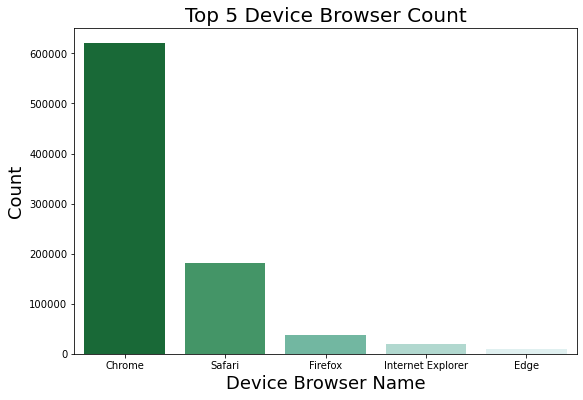

In [25]:
# Set the graph size
plt.figure(figsize=(9,6))
browser_order = dataNew2["device.browser"].value_counts()[:5].sort_values(ascending=False).index

# Explore the browser used by users
sns.countplot(dataNew2["device.browser"], order=browser_order, palette='BuGn_r')
plt.title("Top 5 Device Browser Count", fontsize=20) # Set the title size
plt.xlabel("Device Browser Name", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

The top 5 browsers are Chrome, Safari, Firefox, Internet Explorer, and Edge

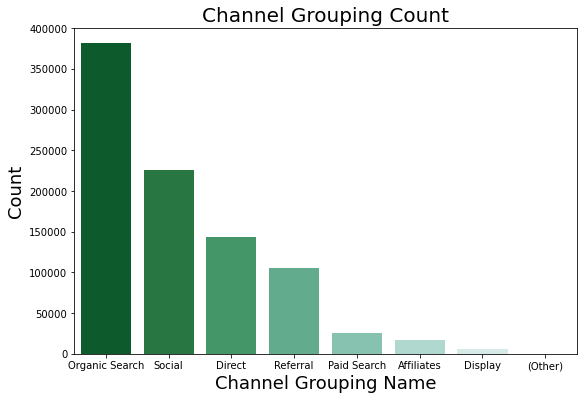

In [26]:
# Channel Grouping Count
plt.figure(figsize=(9,6))
channel_order = dataNew2["channelGrouping"].value_counts().sort_values(ascending=False).index

sns.countplot(dataNew2["channelGrouping"], order=channel_order, palette='BuGn_r')

plt.title("Channel Grouping Count", fontsize=20) # Set the title size
plt.xlabel("Channel Grouping Name", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [57]:
# Channel Grouping Count
start_time = time()
spark.sql("SELECT channelGrouping, COUNT(channelGrouping) FROM viewDF \
            GROUP BY channelGrouping \
            ORDER BY COUNT(channelGrouping) \
            DESC LIMIT 7").show()
end_time = time()
time_taken = end_time - start_time
time_taken

+---------------+----------------------+
|channelGrouping|count(channelGrouping)|
+---------------+----------------------+
| Organic Search|                381561|
|         Social|                226117|
|         Direct|                143026|
|       Referral|                104838|
|    Paid Search|                 25326|
|     Affiliates|                 16403|
|        Display|                  6262|
+---------------+----------------------+



6.988823175430298

After counting the channel, we can see user used the Organic Search the most. Next are Social, Direct, and Referral.

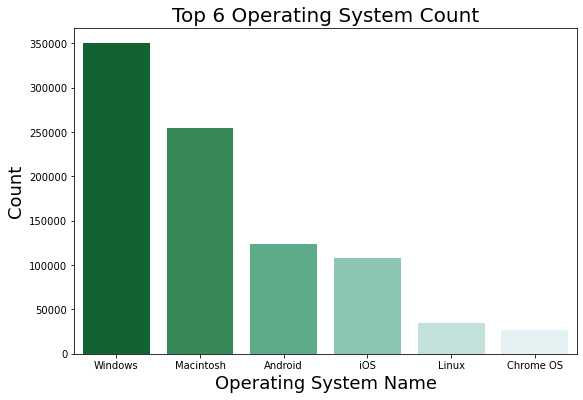

In [27]:
# Top 6 Operating System Count
plt.figure(figsize=(9,6))
operatingSystem_order = dataNew2["device.operatingSystem"].value_counts()[:6].sort_values(ascending=False).index

sns.countplot(dataNew2["device.operatingSystem"], order=operatingSystem_order, palette='BuGn_r')
plt.title("Top 6 Operating System Count", fontsize=20) # Set the title size
plt.xlabel("Operating System Name", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [58]:
# Top 6 Operating System Count
spark.sql("SELECT `device.operatingSystem`, COUNT(`device.operatingSystem`)AS Count FROM viewDF \ 
            GROUP BY `device.operatingSystem` \
            ORDER BY COUNT(`device.operatingSystem`) \
            DESC LIMIT 6").show()

+----------------------+------+
|device.operatingSystem| Count|
+----------------------+------+
|               Windows|350072|
|             Macintosh|253938|
|               Android|123892|
|                   iOS|107665|
|                 Linux| 35034|
|             Chrome OS| 26337|
+----------------------+------+



Top 6 operating systems are Windows, Macintosh, Android, iOS, Linux, Chrome OS

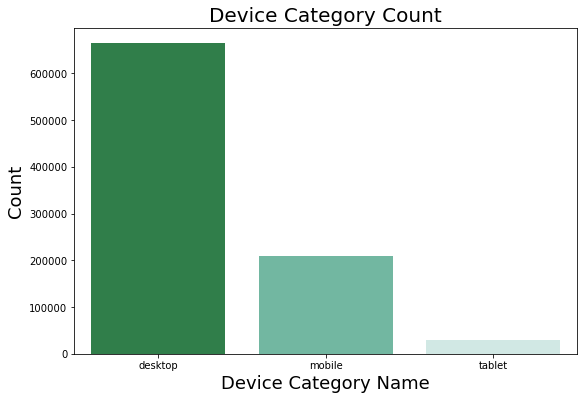

In [28]:
# Device Category Count
plt.figure(figsize=(9,6))
deviceCategory_order = dataNew2["device.deviceCategory"].value_counts().sort_values(ascending=False).index

sns.countplot(dataNew2["device.deviceCategory"], order=deviceCategory_order, palette='BuGn_r')
plt.title("Device Category Count", fontsize=20) # Set the title size
plt.xlabel("Device Category Name", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [59]:
# Device Category Count
spark.sql("""SELECT `device.deviceCategory`, COUNT(`device.deviceCategory`) AS Count \
            FROM viewDF \
            GROUP BY `device.deviceCategory` \
            ORDER BY COUNT(`device.deviceCategory`) \
            DESC LIMIT 6""").show()

+---------------------+------+
|device.deviceCategory| Count|
+---------------------+------+
|              desktop|664479|
|               mobile|208725|
|               tablet| 30449|
+---------------------+------+



From the above plot, we can see users tend to use desktop, then mobile, lastly, tablet.

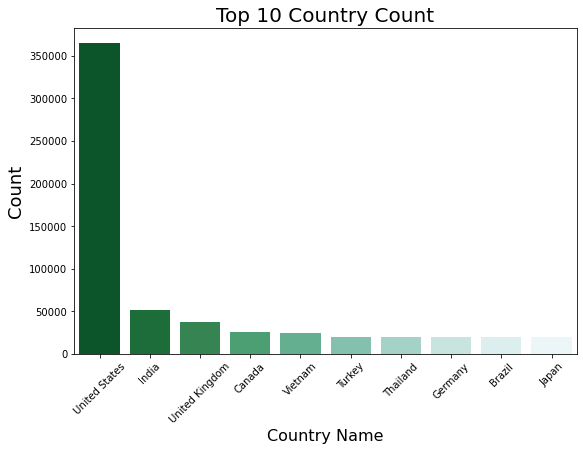

In [29]:
# Top 10 Country Count
plt.figure(figsize=(9,6))
country_order = dataNew2["geoNetwork.country"].value_counts()[:10].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.country"], order=country_order, palette='BuGn_r')
plt.title("Top 10 Country Count", fontsize=20) # Set the title size
plt.xlabel("Country Name", fontsize=16) # Set the x label size
plt.xticks(rotation=45)
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [60]:
# Top 10 Country Count
spark.sql("""SELECT `geoNetwork.country`, COUNT(`geoNetwork.country`) AS Count \
            FROM viewDF \
            GROUP BY `geoNetwork.country` \
            ORDER BY COUNT(`geoNetwork.country`) DESC\
            LIMIT 10""").show()

+------------------+------+
|geoNetwork.country| Count|
+------------------+------+
|     United States|364744|
|             India| 51140|
|    United Kingdom| 37393|
|            Canada| 25869|
|           Vietnam| 24598|
|            Turkey| 20522|
|          Thailand| 20123|
|           Germany| 19980|
|            Brazil| 19783|
|             Japan| 19731|
+------------------+------+



Top 10 countries that users come from are United States, Undia, United Kingdom, Canada, Vietnam, Turkey, Thailand, Germany, Brazil, and Japan

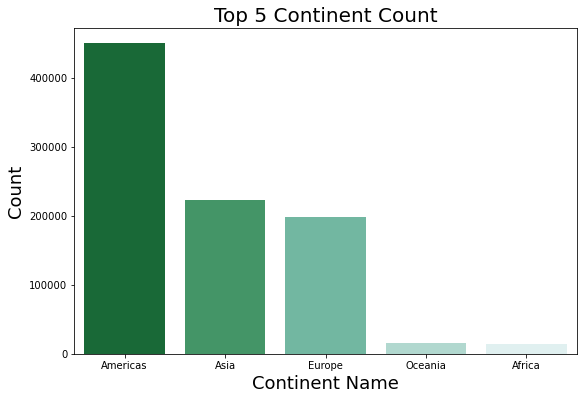

In [30]:
# Top 5 Continent Count
plt.figure(figsize=(9,6))
continent_order = dataNew2["geoNetwork.continent"].value_counts()[:5].sort_values(ascending=False).index

sns.countplot(dataNew2["geoNetwork.continent"], order=continent_order, palette='BuGn_r')
plt.title("Top 5 Continent Count", fontsize=20) # Set the title size
plt.xlabel("Continent Name", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [61]:
# Top 5 Continent Count
spark.sql("""SELECT `geoNetwork.continent`, COUNT(`geoNetwork.continent`) AS Count \
            FROM viewDF \
            GROUP BY `geoNetwork.continent` \
            ORDER BY COUNT(`geoNetwork.continent`) DESC\
            LIMIT 5""").show()

+--------------------+------+
|geoNetwork.continent| Count|
+--------------------+------+
|            Americas|450377|
|                Asia|223698|
|              Europe|198311|
|             Oceania| 15054|
|              Africa| 14745|
+--------------------+------+



Americas is the first Continent that has the most traffic.

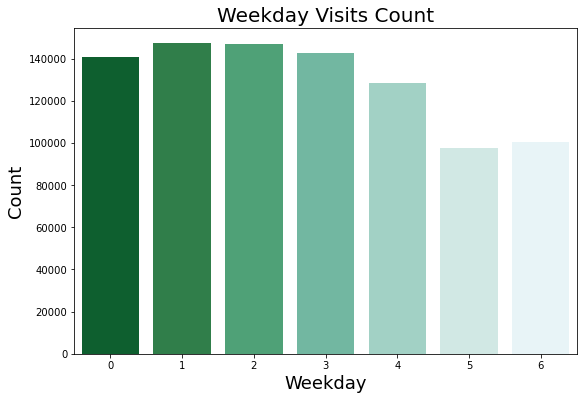

In [31]:
# Weekday Visits Count
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["weekday"], palette='BuGn_r')
plt.title("Weekday Visits Count", fontsize=20) # Set the title size
plt.xlabel("Weekday", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [62]:
# Weekday Visits Count
spark.sql("""SELECT weekday, COUNT(weekday) AS Count \
            FROM viewDF \
            GROUP BY weekday \
            ORDER BY weekday\
            LIMIT 7""").show()

+-------+------+
|weekday| Count|
+-------+------+
|      0|140905|
|      1|147279|
|      2|146733|
|      3|142399|
|      4|128331|
|      5| 97646|
|      6|100360|
+-------+------+



Monday, Tuesday, Wednesday are top 3 weekdays that have the most vist. Surprisingly, weekends contributed the least visits.

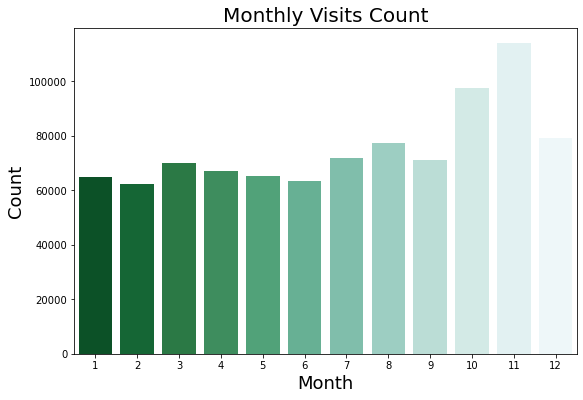

In [32]:
# Monthly Visits Count
plt.figure(figsize=(9,6))

sns.countplot(dataNew2["month"], palette='BuGn_r')
plt.title("Monthly Visits Count", fontsize=20) # Set the title size
plt.xlabel("Month", fontsize=18) # Set the x label size
plt.ylabel("Count", fontsize=18) # Set the y label size

plt.show()

In [63]:
# Monthly Visits Count
spark.sql("""SELECT month, COUNT(month) AS Count \
            FROM viewDF \
            GROUP BY month \
            ORDER BY month\
            LIMIT 12""").show()

+-----+------+
|month| Count|
+-----+------+
|    1| 64694|
|    2| 62192|
|    3| 69931|
|    4| 67126|
|    5| 65371|
|    6| 63578|
|    7| 71812|
|    8| 77315|
|    9| 71032|
|   10| 97506|
|   11|113972|
|   12| 79124|
+-----+------+



October and November have the most visits, while February, May, June have the least.

### Transactions

In [33]:
nz_revenue= pd.notnull(dataNew2["totals.transactionRevenue"]).sum()
print(f"The number of non-zero transaction is {nz_revenue} \nThe ratio is {nz_revenue/dataNew2.shape[0]}")

The number of non-zero transaction is 903653 
The ratio is 1.0


In [34]:
# Create a new df with only non-zero transactions
nz_revenue_df = dataNew2.loc[dataNew2["totals.transactionRevenue"]>0]
nz_revenue_df.head(5)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,weekday,day,month,year,visitHour
752,Direct,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,1472843572,Chrome,Linux,False,...,Ann Arbor,(not set),11.0,11.0,37860000.0,4,2,9,2016,19
753,Organic Search,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,1472844906,Chrome,Macintosh,False,...,New York,(not set),11.0,10.0,306670000.0,4,2,9,2016,19
799,Referral,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,1472827393,Chrome,Linux,False,...,New York,(not set),13.0,11.0,68030000.0,4,2,9,2016,14
802,Referral,2016-09-02,0185467632009737931,0185467632009737931_1472846398,1472846398,6,1472846398,Chrome,Windows,False,...,Mountain View,(not set),13.0,12.0,26250000.0,4,2,9,2016,19
859,Referral,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,1472824817,Chrome,Macintosh,False,...,not available in demo dataset,(not set),17.0,14.0,574150000.0,4,2,9,2016,14


In [35]:
nz_revenue_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11515 entries, 752 to 903317
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   channelGrouping            11515 non-null  object        
 1   date                       11515 non-null  datetime64[ns]
 2   fullVisitorId              11515 non-null  object        
 3   sessionId                  11515 non-null  object        
 4   visitId                    11515 non-null  int64         
 5   visitNumber                11515 non-null  int64         
 6   visitStartTime             11515 non-null  int64         
 7   device.browser             11515 non-null  object        
 8   device.operatingSystem     11515 non-null  object        
 9   device.isMobile            11515 non-null  bool          
 10  device.deviceCategory      11515 non-null  object        
 11  geoNetwork.continent       11515 non-null  object        
 12  g

In [36]:
top5_broswer = ["Chrome", "Safari", "Firefox", "Internet Explorer", "Edge"]

### Total Hits Across Date

<function matplotlib.pyplot.show(*args, **kw)>

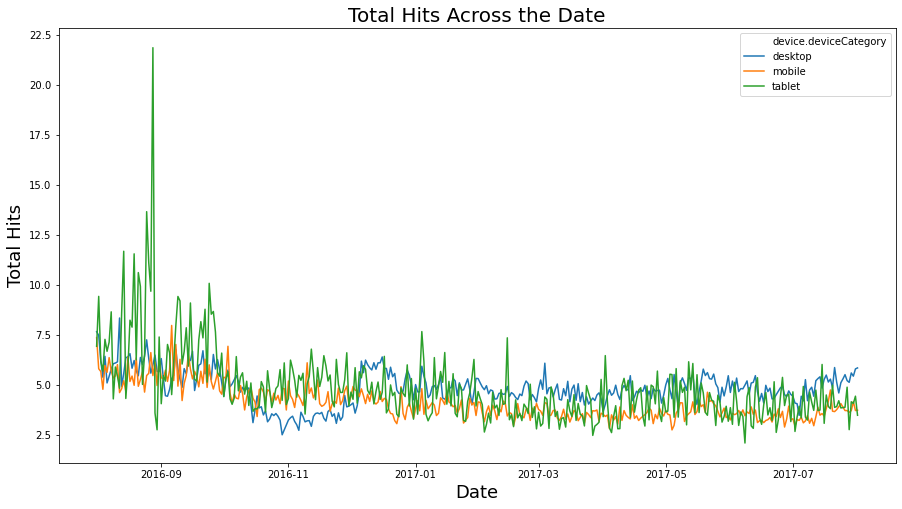

In [37]:
# Daily Hits
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=dataNew2, ci=None, hue="device.deviceCategory")
plt.title("Total Hits Across the Date", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

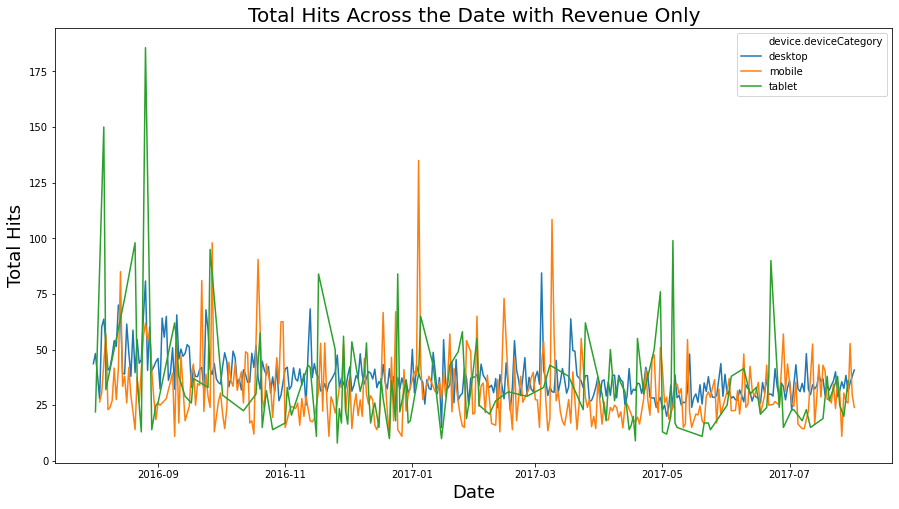

In [38]:
# Total Hits Across the Date with Nonzero Revenue
plt.figure(figsize=(15,8))
sns.lineplot(x="date", y="totals.hits", data=nz_revenue_df, ci=None, hue="device.deviceCategory")
plt.title("Total Hits Across the Date with Revenue Only", fontsize=20)
plt.xlabel("Date", fontsize=18) 
plt.ylabel("Total Hits", fontsize=18)
plt.show

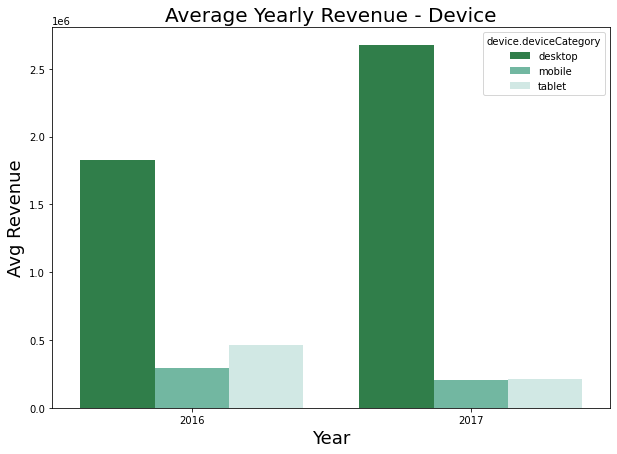

In [39]:
# Average Yearly Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="year", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Average Yearly Revenue - Device", fontsize=20)
plt.xlabel("Year", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18) 

plt.show()

In [64]:
# Average Yearly Revenue - Device
spark.sql("""SELECT year, `device.deviceCategory`, ROUND(AVG(`totals.transactionRevenue`),2) as AvgRevenue \
             FROM viewDF \
             GROUP BY `device.deviceCategory`, year\
             ORDER BY year, AVG(`totals.transactionRevenue`)
             """).show()

+----+---------------------+----------+
|year|device.deviceCategory|AvgRevenue|
+----+---------------------+----------+
|2016|               mobile|  293851.9|
|2016|               tablet|  465511.4|
|2016|              desktop|1830041.77|
|2017|               mobile| 207690.18|
|2017|               tablet| 208882.89|
|2017|              desktop| 2671585.7|
+----+---------------------+----------+



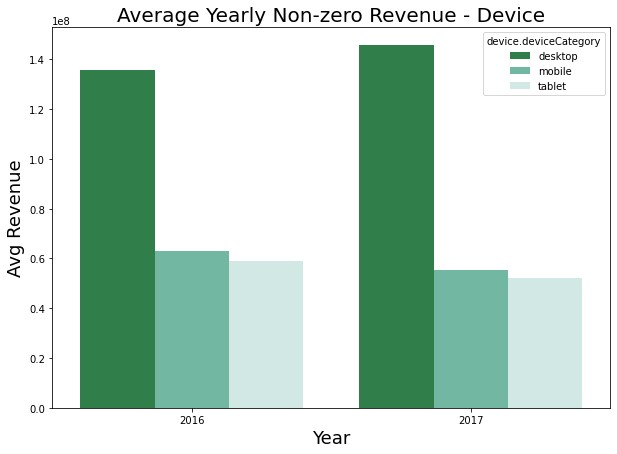

In [40]:
# Average Yearly Nonzero Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="year", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='BuGn_r', ci=None)
plt.title("Average Yearly Non-zero Revenue - Device", fontsize=20) 
plt.xlabel("Year", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18) 

plt.show()

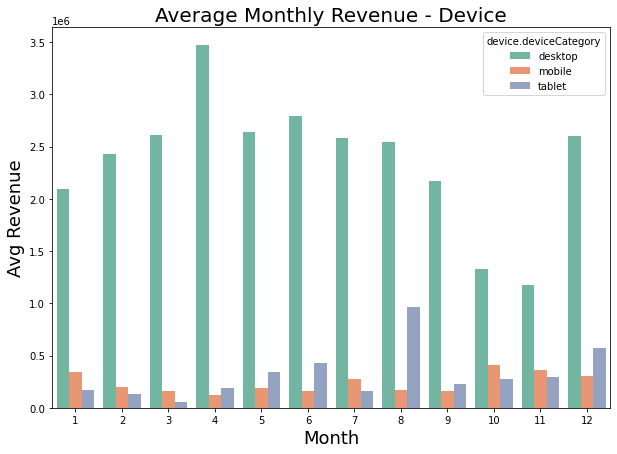

In [41]:
#Average Monthly Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="month", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='Set2', ci=None)
plt.title("Average Monthly Revenue - Device", fontsize=20) 
plt.xlabel("Month", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18) 

plt.show()

In [65]:
# Average Monthly Revenue - Device
spark.sql("""SELECT month, `device.deviceCategory`, ROUND(AVG(`totals.transactionRevenue`), 2) as AvgRevenue \
             FROM viewDF \
             GROUP BY `device.deviceCategory`, month \
             ORDER BY AVG(`totals.transactionRevenue`) DESC \
             LIMIT 20""").show()

+-----+---------------------+----------+
|month|device.deviceCategory|AvgRevenue|
+-----+---------------------+----------+
|    4|              desktop|3467344.88|
|    6|              desktop|2794504.95|
|    5|              desktop| 2641535.2|
|    3|              desktop|2606963.99|
|   12|              desktop|2602488.31|
|    7|              desktop|2581423.84|
|    8|              desktop|2541572.89|
|    2|              desktop| 2425737.3|
|    9|              desktop|2166826.38|
|    1|              desktop|2091168.63|
|   10|              desktop|1331387.62|
|   11|              desktop|1177557.65|
|    8|               tablet| 967459.76|
|   12|               tablet| 567864.08|
|    6|               tablet| 432774.17|
|   10|               mobile| 408295.07|
|   11|               mobile| 364151.48|
|    5|               tablet| 343822.81|
|    1|               mobile| 338345.97|
|   12|               mobile| 302071.55|
+-----+---------------------+----------+



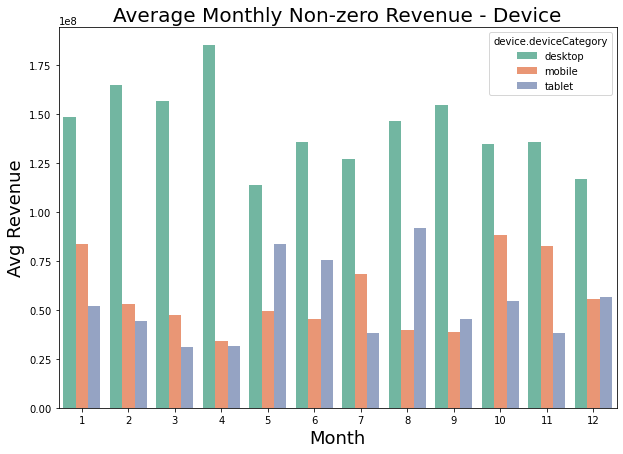

In [42]:
# Average Monthly Nonzero Revenue - Device
plt.figure(figsize=(10,7))

sns.barplot(x="month", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Average Monthly Non-zero Revenue - Device", fontsize=20) 
plt.xlabel("Month", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18) 

plt.show()

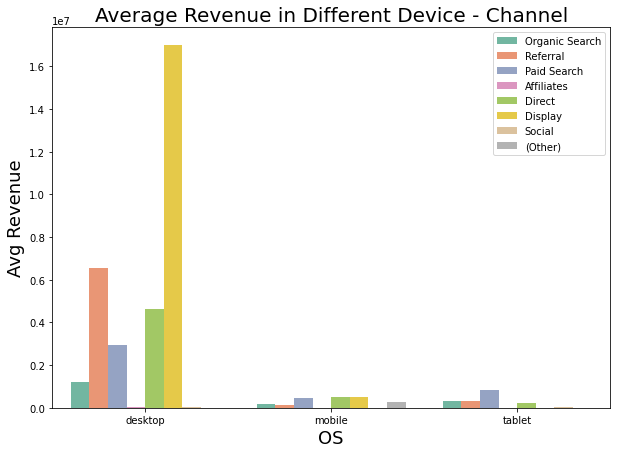

In [43]:
# Average Revenue in Different Device - Channel
plt.figure(figsize=(10,7))

sns.barplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping", data=dataNew2, palette='Set2', ci=None)
plt.title("Average Revenue in Different Device - Channel", fontsize=20) 
plt.ylabel("Avg Revenue", fontsize=18) 
plt.legend(loc = "upper right")

plt.show()

In [66]:
# Average Revenue in Different Device - Channel
spark.sql("""SELECT `device.deviceCategory`, `channelGrouping`,  ROUND(AVG(`totals.transactionRevenue`), 2) as AvgRevenue
            FROM viewDF
            GROUP BY `device.deviceCategory`, `channelGrouping`
            ORDER BY AVG(`totals.transactionRevenue`) DESC, `channelGrouping`
            """).show()

+---------------------+---------------+-------------+
|device.deviceCategory|channelGrouping|   AvgRevenue|
+---------------------+---------------+-------------+
|              desktop|        Display|1.698615772E7|
|              desktop|       Referral|   6561004.04|
|              desktop|         Direct|   4645055.22|
|              desktop|    Paid Search|   2921725.58|
|              desktop| Organic Search|   1225948.27|
|               tablet|    Paid Search|    848960.11|
|               mobile|        Display|     517327.7|
|               mobile|         Direct|     490183.1|
|               mobile|    Paid Search|    449558.13|
|               tablet| Organic Search|     331327.5|
|               tablet|       Referral|    326971.08|
|               mobile|        (Other)|    293823.53|
|               tablet|         Direct|    239252.79|
|               mobile| Organic Search|    162103.03|
|               mobile|       Referral|    138732.11|
|              desktop|     

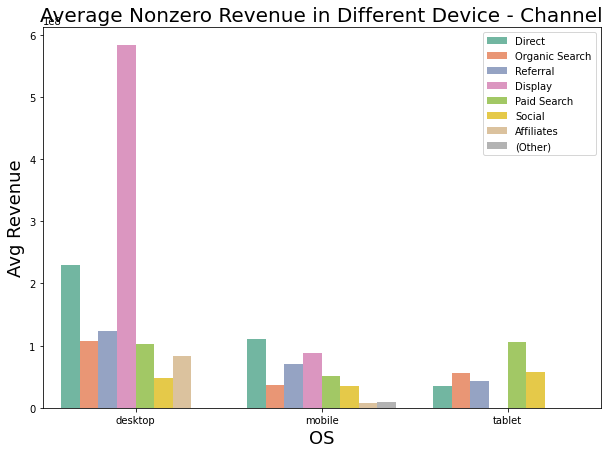

In [44]:
# Average Nonzero Revenue in Different Device - Channel
plt.figure(figsize=(10,7))

sns.barplot(x="device.deviceCategory", y="totals.transactionRevenue", hue="channelGrouping", data=nz_revenue_df, palette='Set2', ci=None)
plt.title("Average Nonzero Revenue in Different Device - Channel", fontsize=20) 
plt.xlabel("OS", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18) 
plt.legend(loc = "upper right")

plt.show()

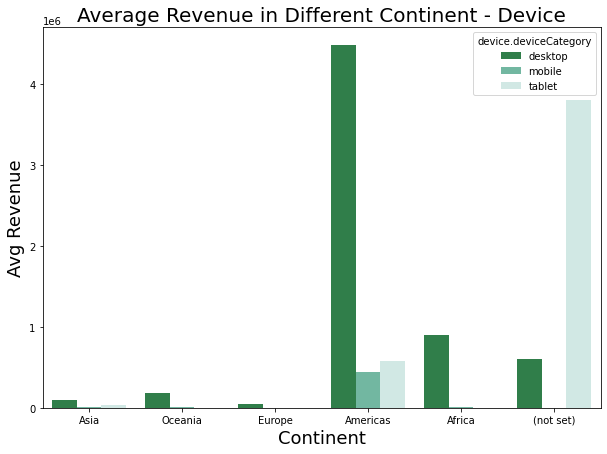

In [45]:
# Average Revenue in Different Continent - Device
plt.figure(figsize=(10,7))

sns.barplot(x="geoNetwork.continent", y="totals.transactionRevenue", hue="device.deviceCategory", data=dataNew2, palette='BuGn_r', ci=None)
plt.title("Average Revenue in Different Continent - Device", fontsize=20) 
plt.xlabel("Continent", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18) 

plt.show()

In [67]:
# Average Revenue in Different Continent - Device
spark.sql("""SELECT `device.deviceCategory`, `geoNetwork.continent`,  ROUND(AVG(`totals.transactionRevenue`), 2) as AvgRevenue
            FROM viewDF
            GROUP BY `device.deviceCategory`, `geoNetwork.continent`
            ORDER BY AVG(`totals.transactionRevenue`) DESC, `geoNetwork.continent`
            """).show()

+---------------------+--------------------+----------+
|device.deviceCategory|geoNetwork.continent|AvgRevenue|
+---------------------+--------------------+----------+
|              desktop|            Americas| 4471520.5|
|               tablet|           (not set)|3792285.71|
|              desktop|              Africa| 902298.37|
|              desktop|           (not set)| 603267.05|
|               tablet|            Americas| 576985.72|
|               mobile|            Americas| 440704.92|
|              desktop|             Oceania| 176925.39|
|              desktop|                Asia|  94781.91|
|              desktop|              Europe|  45653.94|
|               tablet|                Asia|  30005.27|
|               mobile|                Asia|  15341.04|
|               mobile|              Africa|  10451.19|
|               mobile|             Oceania|   7543.68|
|               mobile|              Europe|   2675.51|
|               mobile|           (not set)|    

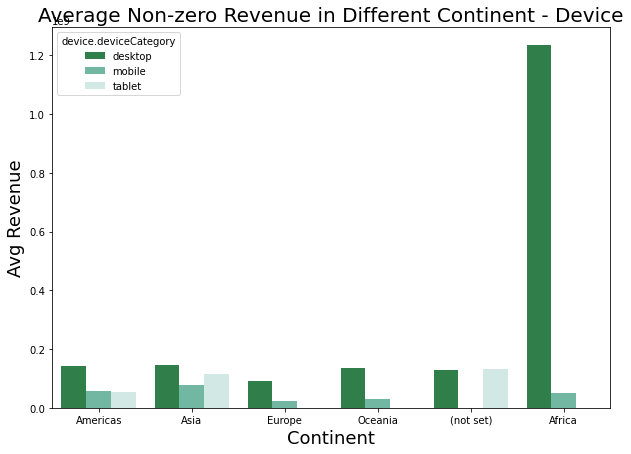

In [46]:
# Average Nonzero Revenue in Different Continent - Device
plt.figure(figsize=(10,7))

sns.barplot(x="geoNetwork.continent", y="totals.transactionRevenue", hue="device.deviceCategory", data=nz_revenue_df, palette='BuGn_r', ci=None)
plt.title("Average Non-zero Revenue in Different Continent - Device", fontsize=20)
plt.xlabel("Continent", fontsize=18) 
plt.ylabel("Avg Revenue", fontsize=18)

plt.show()

## Model Building
* We want to predict whether the total transaction revenue is high or low?
* Also, we want to predict whether a visitor will make transaction?

Before building the model, we first look at the correlation between variables in the dataset by removing non-numerical columns and plot the correlation matrix.

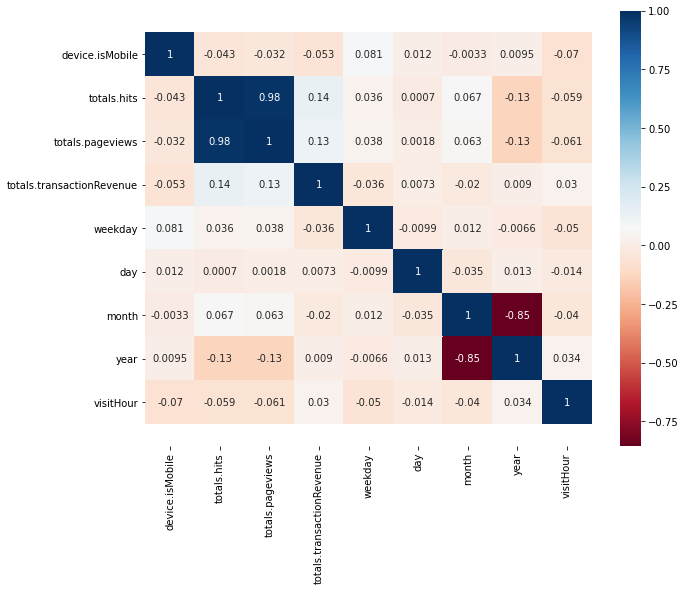

In [68]:
df = nz_revenue_df[["device.isMobile", "totals.hits", "totals.pageviews", "totals.transactionRevenue", "weekday", "day", "month", "year", "visitHour"]]
plt.figure(figsize=(10,8))
corrMatrix = df.corr()
ax = sns.heatmap(corrMatrix, annot=True, fmt='.2g', cmap= 'RdBu')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

From the above correlation matrix, we can see that only total hits and total pageviews have relatively significant positive correlation with total transaction revenue. Moreover, totoal hits and total pageviews seem to be highly correlated with each others.

### Predict Total Transaction Revenue 
In this part, we apply random forest classifier to predict the total transaction revenue level for each visitor. 
Here we define the total transaction revenue into three levels, "High", "Mid", and "Low", based on the statistics quantile.

In [69]:
# Load Data
df_nz = pd.read_csv("s3://largedataset-project-bucket/nz_revenue.csv")

#### Data Wrangling and Processing

In [70]:
# Deal with date data
df_nz['date'] = pd.to_datetime(df_nz['date'])
df_nz['month_str'] = df_nz['date'].apply(lambda time: time.strftime('%B'))
df_nz['weekday_str'] = df_nz['date'].apply(lambda time: time.strftime('%A'))

In [71]:
# Check the statistics of totals.transactionRevenue
df_nz["totals.transactionRevenue"].describe()

count    1.151500e+04
mean     1.337448e+08
std      4.482852e+08
min      1.000000e+04
25%      2.493000e+07
50%      4.945000e+07
75%      1.076550e+08
max      2.312950e+10
Name: totals.transactionRevenue, dtype: float64

In [72]:
# Create a new column called 'revenue' as predicted target in the model
# High revenue means the total transaction revenue is higher than 75% quantile, which is 107,740,000
# Low revenue means the total transaction revenue is lower than 25% quantile, which is 24,930,000
# Mid revenue means the total transaction revenue is in between 25% to 75% quantile
df_nz['revenue_high'] = df_nz["totals.transactionRevenue"].apply(lambda x: 1 if x >1.076550e+08 else 0)
df_nz['revenue_mid'] = df_nz["totals.transactionRevenue"].apply(lambda x: 1 if (x >2.493000e+07)and (x <1.076550e+08) else 0)
df_nz['revenue_low'] = df_nz["totals.transactionRevenue"].apply(lambda x: 1 if x <2.493000e+07 else 0)

In [73]:
df_nz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11515 entries, 0 to 11514
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   channelGrouping            11515 non-null  object        
 1   date                       11515 non-null  datetime64[ns]
 2   fullVisitorId              11515 non-null  uint64        
 3   sessionId                  11515 non-null  object        
 4   visitId                    11515 non-null  int64         
 5   visitNumber                11515 non-null  int64         
 6   visitStartTime             11515 non-null  int64         
 7   device.browser             11515 non-null  object        
 8   device.operatingSystem     11515 non-null  object        
 9   device.isMobile            11515 non-null  bool          
 10  device.deviceCategory      11515 non-null  object        
 11  geoNetwork.continent       11515 non-null  object        
 12  geoN

In [74]:
df_nz.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,...,weekday,day,month,year,visitHour,month_str,weekday_str,revenue_high,revenue_mid,revenue_low
0,Direct,2016-09-02,6194193421514403509,6194193421514403509_1472843572,1472843572,1,1472843572,Chrome,Linux,False,...,4,2,9,2016,19,September,Friday,0,1,0
1,Organic Search,2016-09-02,5327166854580374902,5327166854580374902_1472844906,1472844906,3,1472844906,Chrome,Macintosh,False,...,4,2,9,2016,19,September,Friday,1,0,0
2,Referral,2016-09-02,8885051388942907862,8885051388942907862_1472827393,1472827393,7,1472827393,Chrome,Linux,False,...,4,2,9,2016,14,September,Friday,0,1,0
3,Referral,2016-09-02,185467632009737931,0185467632009737931_1472846398,1472846398,6,1472846398,Chrome,Windows,False,...,4,2,9,2016,19,September,Friday,0,1,0
4,Referral,2016-09-02,3244885836845029978,3244885836845029978_1472824817,1472824817,4,1472824817,Chrome,Macintosh,False,...,4,2,9,2016,14,September,Friday,1,0,0


In [75]:
# Drop columns that will not be used in the model
df_nz = df_nz.drop(["date", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 
              "geoNetwork.continent", "geoNetwork.subContinent","geoNetwork.region", "geoNetwork.metro", "geoNetwork.city", "geoNetwork.networkDomain", 
                    "month", "weekday", "day", "year"], axis = 1)

In [76]:
# Deal with boolean value
df_nz['device.isMobile'] = (df_nz['device.isMobile'] == 'True').astype(int)

/home/hadoop/miniconda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [77]:
# Label encoding the Categorical variables
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["channelGrouping", "device.browser", "device.operatingSystem", 
                       "geoNetwork.country", "device.deviceCategory", "month_str", "weekday_str"]

le = LabelEncoder()
for col in categorical_columns:
    encoded_col  = list(df_nz[col].values.astype(str))
    le.fit(encoded_col)
    df_nz[col] = le.transform(encoded_col)

#### Model Preparation

In [78]:
# Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn import tree, metrics

In [79]:
ml = df_nz

In [80]:
ml_df = ml.drop(['totals.transactionRevenue'], axis = 1)
X = ml_df.drop(['revenue_high', 'revenue_mid', 'revenue_low'], axis = 1)
y = ml_df[['revenue_high', 'revenue_mid', 'revenue_low']]

In [81]:
# Create a train-test data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=10)

In [82]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8060 entries, 6765 to 1289
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   channelGrouping         8060 non-null   int64  
 1   visitNumber             8060 non-null   int64  
 2   device.browser          8060 non-null   int64  
 3   device.operatingSystem  8060 non-null   int64  
 4   device.isMobile         8060 non-null   int64  
 5   device.deviceCategory   8060 non-null   int64  
 6   geoNetwork.country      8060 non-null   int64  
 7   totals.hits             8060 non-null   float64
 8   totals.pageviews        8060 non-null   float64
 9   visitHour               8060 non-null   int64  
 10  month_str               8060 non-null   int64  
 11  weekday_str             8060 non-null   int64  
dtypes: float64(2), int64(10)
memory usage: 818.6 KB


#### Apply Random Forest and XGBoost Classifier

In [83]:
!pip install xgboost

In [84]:
# Import Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from xgboost import plot_tree

In [85]:
# Create a Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=10)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=500,
                       random_state=10)

In [86]:
# Testing Accuracy
y_pred = rf_model.predict(X_test)
print(accuracy_score(y_test.values.argmax(axis = 1), y_pred.argmax(axis = 1)))

0.4639652677279305


In [87]:
# Create a XGBoost Classifier
xgb_model = XGBClassifier(learning_rate =0.01, n_estimators=500, max_depth=5, 
                          objective= 'multi:softmax', num_class=3, seed=27)
xgb_model.fit(X_train, np.argmax(y_train.to_numpy(), axis = 1))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=0, num_class=3, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=27, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [88]:
# Testing Accuracy
y_pred = xgb_model.predict(X_test)
print(classification_report(np.argmax(y_test.to_numpy(), axis = 1),y_pred))
print("Accuracy of Testing Data:",metrics.accuracy_score(np.argmax(y_test.to_numpy(), axis = 1), y_pred))

              precision    recall  f1-score   support

           0       0.57      0.28      0.37       842
           1       0.54      0.84      0.65      1735
           2       0.53      0.21      0.30       878

    accuracy                           0.54      3455
   macro avg       0.54      0.44      0.44      3455
weighted avg       0.54      0.54      0.50      3455

Accuracy of Testing Data: 0.5409551374819103


In [89]:
conda install python-graphviz

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


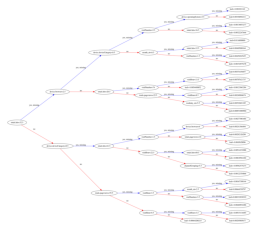

In [90]:
# Plot Tree
plot_tree(xgb_model, num_trees=5, rankdir='LR')
plt.show()

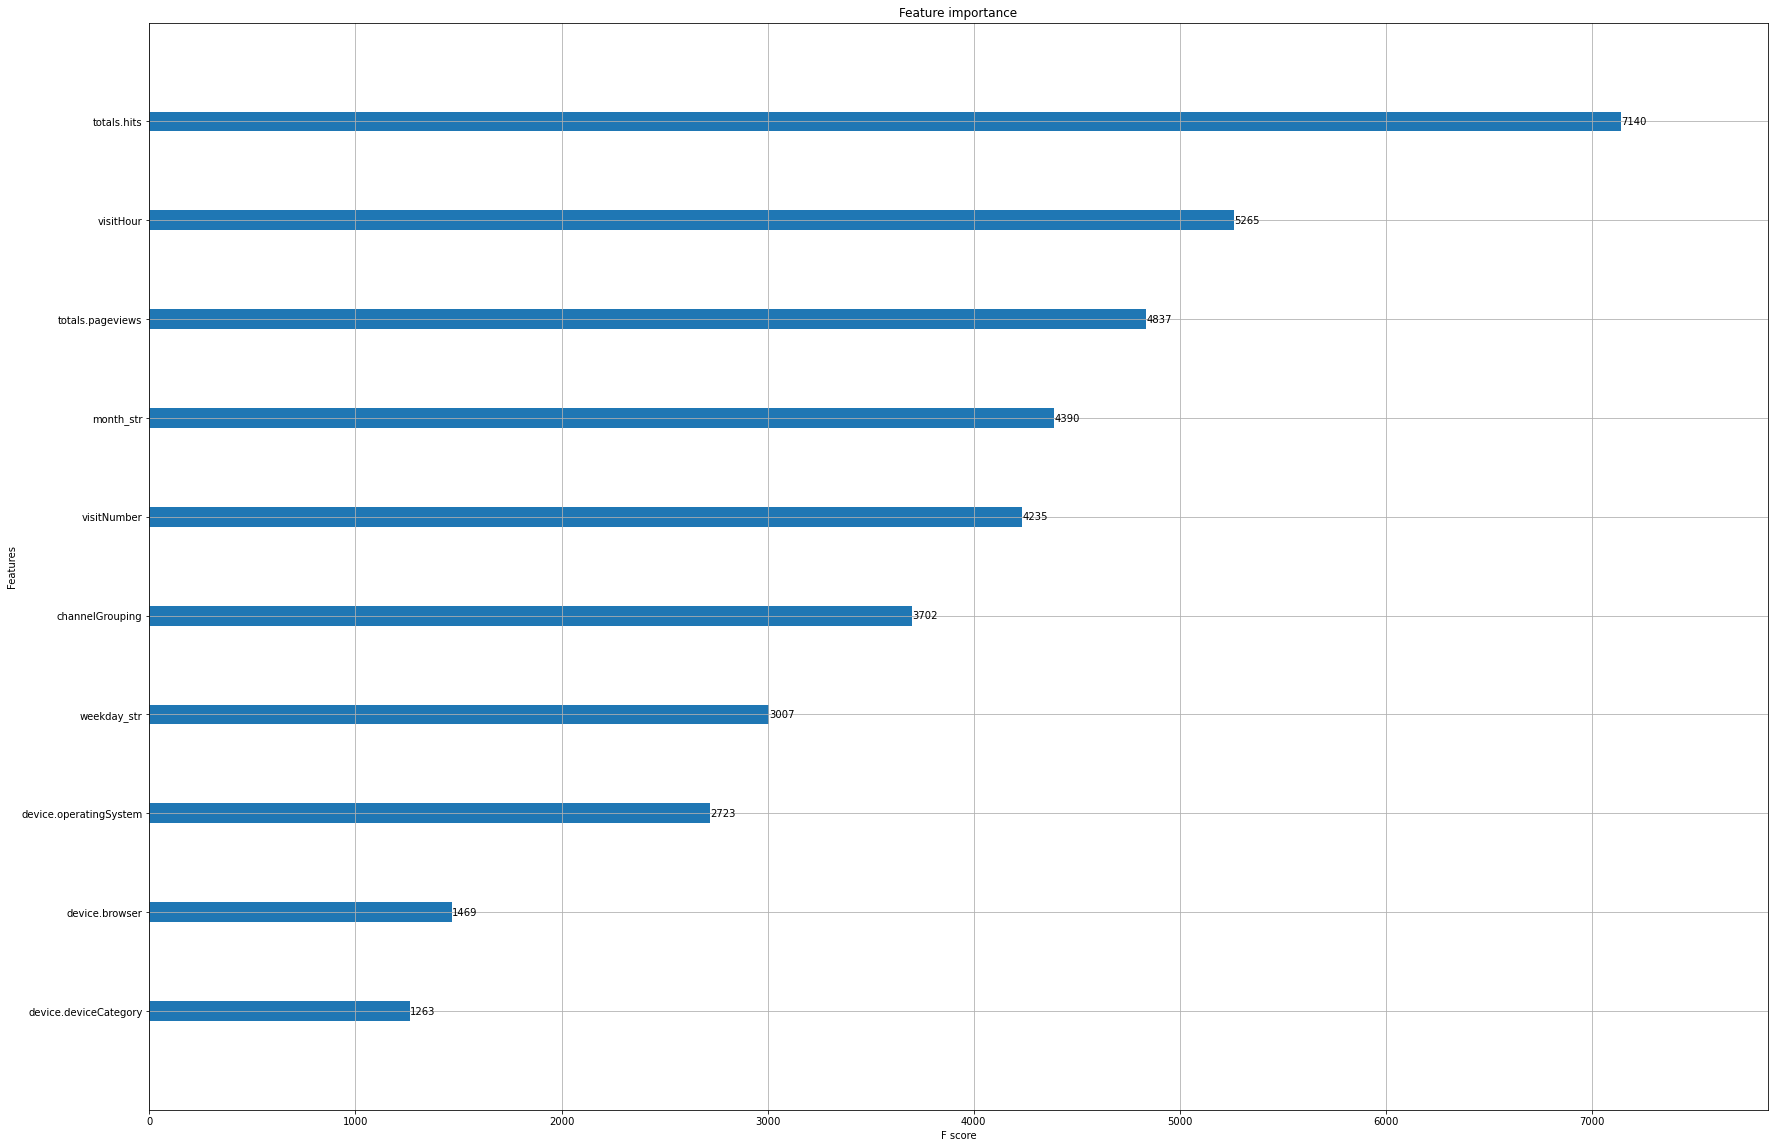

In [91]:
# Plot Feature Importance
plt.rcParams["figure.figsize"] = (29, 20)
plot_importance(xgb_model, max_num_features=10)

#### From the above results, we can see that total hits, visit hour and total pageviews are the top 3 important features when predicting the visitor's total transaction revenue. Whether the visit is the first session is also an important element when predicting. Therefore, in below we would like to explore more about the relationship between total transaction revenue and total hits, visit hour and visit number.

In [92]:
# Create a new column called 'first_session'
df_nz['first_session'] = df_nz["visitNumber"].apply(lambda x: 0 if x > 1 else 1)
# Create a new column called 'revenue'
def conditions(df):
    if (df['totals.transactionRevenue'] > 1.076550e+08):
        return 3
    elif (df['totals.transactionRevenue'] < 2.493000e+07):
        return 1
    else:
        return 2
df_nz['revenue'] = df_nz.apply(conditions, axis=1)

Text(0.5, 1.0, 'Total Hits v.s. Frequency')

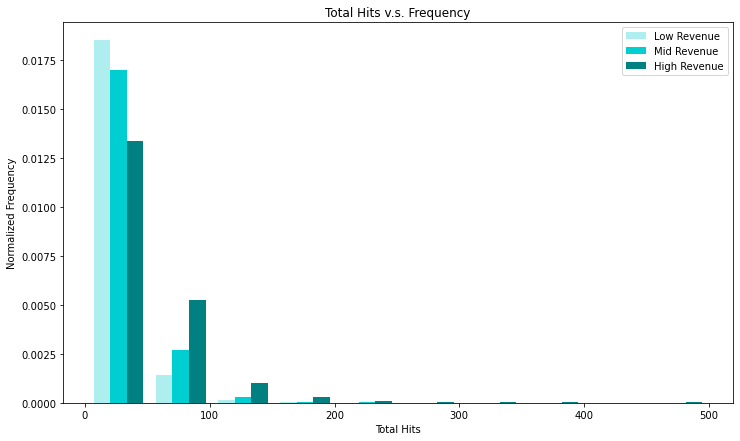

In [95]:
# Total Hits vs Frequency
fig = plt.figure(figsize=(12, 7))
x1 = list(df_nz[df_nz.revenue == 1]['totals.hits'])
x2 = list(df_nz[df_nz.revenue == 2]['totals.hits'])
x3 = list(df_nz[df_nz.revenue == 3]['totals.hits'])

# Assign colors for each labels and the names
colors = ['paleturquoise', 'darkturquoise', 'teal']
names = ['Low Revenue', 'Mid Revenue', 'High Revenue']
         
# Make the histogram using a list of lists
# Normalize the frequency and assign colors and names
plt.hist([x1, x2, x3], density = 1, color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Total Hits')
plt.ylabel('Normalized Frequency')
plt.title('Total Hits v.s. Frequency')

From the above graph, we can see that majority of the visitors in three revenue group have total hits between range of 0 and 100. Moreover, most of the visitors whose transaction revenue is low have the lowest total hits. As for the visitors who spent high total revenue on the website, some of their total hits seem to be relatively high comparing to the other two groups. 

Text(0.5, 1.0, 'Visit Hours v.s. Frequency')

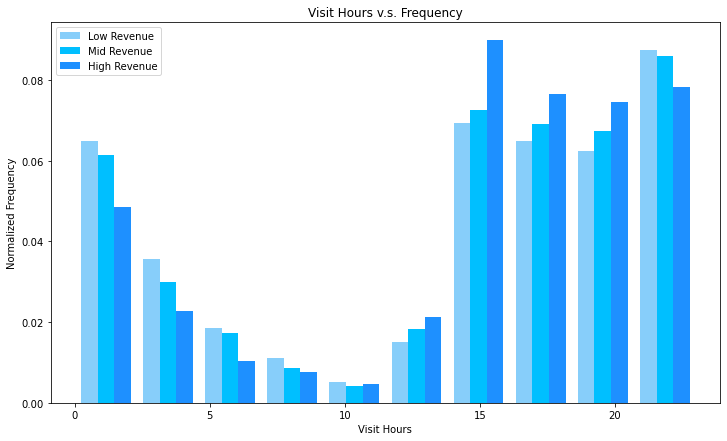

In [94]:
# Visit Hours vs Frequency
fig = plt.figure(figsize=(12, 7))
x1 = list(df_nz[df_nz.revenue == 1]['visitHour'])
x2 = list(df_nz[df_nz.revenue == 2]['visitHour'])
x3 = list(df_nz[df_nz.revenue == 3]['visitHour'])

# Assign colors for each labels and the names
colors = ['lightskyblue', 'deepskyblue', 'dodgerblue']
names = ['Low Revenue', 'Mid Revenue', 'High Revenue']
         
# Make the histogram using a list of lists
# Normalize the frequency and assign colors and names
plt.hist([x1, x2, x3], density = 1, color = colors, label=names)

# Plot formatting
plt.legend()
plt.xlabel('Visit Hours')
plt.ylabel('Normalized Frequency')
plt.title('Visit Hours v.s. Frequency')

In [148]:
df_nz['visitHour'].describe()

count    11515.000000
mean        14.127139
std          7.347617
min          0.000000
25%          7.000000
50%         17.000000
75%         20.000000
max         23.000000
Name: visitHour, dtype: float64

From the above graph, we can see that the distribution of the visit hours seems to be biopolar, only a few have visit hours around 10 hours. When the visit hours are low, less than 5 hours, visitors tend to spend lower. The reason of this might be, when people tend to buy low-price items on the website, they don't need to hesitate for a long time. On the other hand, when the visit hours are high, more than 10 hours, the majority og visitors spend higher. It is reasonable since most of the people would think twice and browsing around the website before buying expensive items. There is an interesting part of the graph, for the visit hours are higher than 20 hours, visitors whose transaction revenue is low seem to be the majority among three groups.

Text(0.5, 1.0, 'Total Transaction Revenue v.s. First Time Visit')

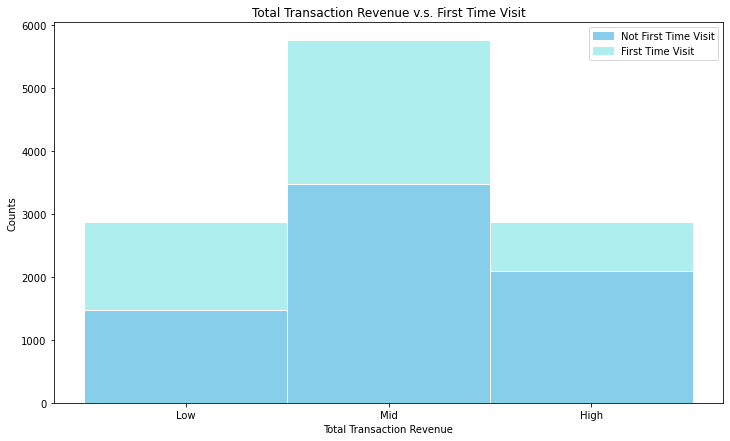

In [93]:
# Revenue v.s. First Session
fig = plt.figure(figsize=(12,7))
revenue_level = [1,2,3]
x1 = []
for i in range(1,4,1):
    x1.append(len(df_nz[(df_nz['first_session'] == 0) & (df_nz['revenue'] == i)]))
    
x2 = []
for i in range(1,4,1):
    x2.append(len(df_nz[(df_nz['first_session'] == 1) & (df_nz['revenue'] == i)]))

# Assign colors and the names
colors = ['skyblue', 'lightcoral']
names = ['Not First Session', 'First Session']

# Names of group and bar width
names = ['Low','Mid','High']
barWidth = 1
         
# Create lower bars
plt.bar(revenue_level, x1, color='skyblue', edgecolor='white', width=barWidth)
# Create upper bars, on top of the first ones
plt.bar(revenue_level, x2, bottom=x1, color='paleturquoise', edgecolor='white', width=barWidth)


# Plot formatting
plt.xticks(revenue_level, names)
plt.xlabel("Total Transaction Revenue")
plt.ylabel('Counts')
blue_patch = mpatches.Patch(color='skyblue', label='Not First Session')
pink_patch = mpatches.Patch(color='paleturquoise', label='First Session')
plt.legend(handles=[blue_patch, pink_patch])
plt.title('Total Transaction Revenue v.s. First Session')

From the above graph, we can see that among the low transaction revenue group, visitor are in the first session and visitors are not in the first seem to be 50% and 50%. On the other hand, among the mid and high transaction revenue groups, majority of the visitors are not in the first session. It might because visitors who spend more have already been through the website before or have already browsing around the website many time before making transaction.

### Try in Pyspark

In [96]:
# Load data
df_ml = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project-bucket/nz_revenue.csv')

#### Data Wrangling and Processing

In [97]:
# Rename columns with dot to prevent system error in the further machine learning process
import re
df_ml = df_ml.toDF(*(re.sub(r'[\.\s]+', '_', c) for c in df_ml.columns))

In [98]:
df_ml.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- fullVisitorId: decimal(19,0) (nullable = true)
 |-- sessionId: string (nullable = true)
 |-- visitId: integer (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- visitStartTime: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_subContinent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- geoNetwork_region: string (nullable = true)
 |-- geoNetwork_metro: string (nullable = true)
 |-- geoNetwork_city: string (nullable = true)
 |-- geoNetwork_networkDomain: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: doub

In [99]:
# Drop columns that will not be used for model building
columns_to_drop = ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitStartTime','geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_networkDomain', 'day', 'year']
df_ml_2 = df_ml.drop(*columns_to_drop)

In [100]:
df_ml_2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)



In [101]:
# Deal with boolean type columns
from pyspark.sql.functions import col
df_ml_2 = df_ml_2.withColumn("device_isMobile", df_ml_2["device_isMobile"].cast("integer"))

In [102]:
# Calculate the quantile of total transaction revenue
df_ml_2.approxQuantile('totals_transactionRevenue', [0.25, 0.5, 0.75], 0)

[24930000.0, 49450000.0, 107740000.0]

In [103]:
# Create a new column called 'revenue' as predicted target in the model
# High revenue means the total transaction revenue is higher than 75% quantile, which is 107,740,000
# Low revenue means the total transaction revenue is lower than 25% quantile, which is 24,930,000
# Mid revenue means the total transaction revenue is in between 25% to 75% quantile

from pyspark.sql import functions as F
df_ml_3 = df_ml_2.withColumn(
    'revenue',
    F.when(F.col("totals_transactionRevenue") > 107740000.0, 'High')\
    .when(F.col("totals_transactionRevenue").between(24930000.0,107740000.0), 'Mid')\
    .when(F.col("totals_transactionRevenue") < 24930000.0, 'Low')
)

In [104]:
df_ml_3.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- revenue: string (nullable = true)



In [105]:
# Deal with string columns
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
stringIndexer_channel = StringIndexer(inputCol="channelGrouping", outputCol="channel")
stringIndexer_browser = StringIndexer(inputCol="device_browser", outputCol="browser")
stringIndexer_system = StringIndexer(inputCol="device_operatingSystem", outputCol="system")
stringIndexer_devicetype = StringIndexer(inputCol="device_deviceCategory", outputCol="device_type")
stringIndexer_continent = StringIndexer(inputCol="geoNetwork_continent", outputCol="continent")
stringIndexer_revenue = StringIndexer(inputCol="revenue", outputCol="revenue_level")

In [106]:
revenue_fit = StringIndexer(inputCol="revenue", outputCol="revenue_level").fit(df_ml_3)

In [107]:
revenue_fit.labels

['Mid', 'High', 'Low']

In [108]:
from pyspark.ml import Pipeline
pipeline_string_index = Pipeline(stages=[stringIndexer_channel, 
                               stringIndexer_browser, 
                               stringIndexer_system, 
                               stringIndexer_devicetype, 
                               stringIndexer_continent, stringIndexer_revenue])
df_ml_4 = pipeline_string_index.fit(df_ml_3).transform(df_ml_3)

In [109]:
df_ml_4.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- revenue: string (nullable = true)
 |-- channel: double (nullable = false)
 |-- browser: double (nullable = false)
 |-- system: double (nullable = false)
 |-- device_type: double (nullable = false)
 |-- continent: double (nullable = false)
 |-- revenue_level: double (nullable = false)



In [110]:
# Create columns that contains all the features by using vector assembler
vectorAssembler_feature = VectorAssembler(inputCols = ['channel',
                                                       'visitNumber',
                                                       'browser', 
                                                       'system',
                                                       'device_type', 
                                                       'continent',
                                                       'totals_hits', 
                                                       'totals_pageviews', 
                                                       'visitHour'], 
                                          outputCol = 'features')

In [111]:
vectorAssembler_feature 

VectorAssembler_4ef6c47a6b12

In [112]:
df_ml_clean = vectorAssembler_feature.transform(df_ml_4)

In [113]:
df_ml_clean.take(3)

[Row(channelGrouping='Direct', visitNumber=1, device_browser='Chrome', device_operatingSystem='Linux', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Americas', geoNetwork_country='United States', totals_hits=11.0, totals_pageviews=11.0, totals_transactionRevenue=37860000.0, weekday=4, month=9, visitHour=19, revenue='Mid', channel=2.0, browser=0.0, system=3.0, device_type=0.0, continent=0.0, revenue_level=0.0, features=DenseVector([2.0, 1.0, 0.0, 3.0, 0.0, 0.0, 11.0, 11.0, 19.0])),
 Row(channelGrouping='Organic Search', visitNumber=3, device_browser='Chrome', device_operatingSystem='Macintosh', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Americas', geoNetwork_country='United States', totals_hits=11.0, totals_pageviews=10.0, totals_transactionRevenue=306670000.0, weekday=4, month=9, visitHour=19, revenue='High', channel=1.0, browser=0.0, system=0.0, device_type=0.0, continent=0.0, revenue_level=1.0, features=DenseVector([1.0, 3.0,

#### Split the dataset to training and test data

In [115]:
split = df_ml_clean.randomSplit([0.7, 0.3], seed = 100)
df_train = split[0].select(['features', 'revenue_level'])
df_test = split[1].select(['features', 'revenue_level'])

In [116]:
df_train.printSchema()

root
 |-- features: vector (nullable = true)
 |-- revenue_level: double (nullable = false)



In [117]:
df_train.show(3)

+--------------------+-------------+
|            features|revenue_level|
+--------------------+-------------+
|[7.0,1.0,0.0,4.0,...|          2.0|
|[6.0,1.0,0.0,5.0,...|          2.0|
|[6.0,1.0,0.0,0.0,...|          1.0|
+--------------------+-------------+
only showing top 3 rows



#### Apply Random Forest Classification

In [118]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="revenue_level", featuresCol="features")

In [119]:
rf_model = rf.fit(df_train)

In [120]:
predictions = rf_model.transform(df_test)
predictions.select("prediction", "revenue_level", "features").show(5)

+----------+-------------+--------------------+
|prediction|revenue_level|            features|
+----------+-------------+--------------------+
|       0.0|          2.0|[6.0,2.0,0.0,0.0,...|
|       0.0|          2.0|[6.0,2.0,1.0,4.0,...|
|       0.0|          2.0|[6.0,3.0,0.0,0.0,...|
|       0.0|          2.0|[6.0,3.0,0.0,1.0,...|
|       2.0|          2.0|[2.0,1.0,0.0,5.0,...|
+----------+-------------+--------------------+
only showing top 5 rows



In [121]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluatorRF = MulticlassClassificationEvaluator(labelCol="revenue_level", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorRF.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.528096
Test Error = 0.471904


In [122]:
predictions.show(3)

+--------------------+-------------+--------------------+--------------------+----------+
|            features|revenue_level|       rawPrediction|         probability|prediction|
+--------------------+-------------+--------------------+--------------------+----------+
|[6.0,2.0,0.0,0.0,...|          2.0|[10.7414273431689...|[0.53707136715844...|       0.0|
|[6.0,2.0,1.0,4.0,...|          2.0|[9.88284887644183...|[0.49414244382209...|       0.0|
|[6.0,3.0,0.0,0.0,...|          2.0|[10.4495006560407...|[0.52247503280203...|       0.0|
+--------------------+-------------+--------------------+--------------------+----------+
only showing top 3 rows



### Predict Making Transaction or Not
In this part, we apply gradient boosting classifier to predict whether the visitor will make transaction. 

#### Data Wrangling and Processing

In [123]:
# Load data
df_ml2 = spark.read\
    .format('csv')\
    .option('header', 'true')\
    .option('inferSchema', 'true')\
    .load('s3://largedataset-project-bucket/DataNew2.csv')

In [124]:
# Rename columns with dot to prevent system error in the further machine learning process
import re
df_ml2 = df_ml2.toDF(*(re.sub(r'[\.\s]+', '_', c) for c in df_ml.columns))

In [125]:
# Drop columns that will not be used for model building
columns_to_drop = ['date', 'fullVisitorId', 'sessionId', 'visitId', 'visitStartTime','geoNetwork_subContinent', 'geoNetwork_region', 'geoNetwork_metro', 'geoNetwork_city', 'geoNetwork_networkDomain', 'day', 'year']
df_ml2_2 = df_ml2.drop(*columns_to_drop)

In [126]:
df_ml2_2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: boolean (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)



In [127]:
# Deal with boolean type columns
from pyspark.sql.functions import col
df_ml2_3 = df_ml2_2.withColumn("device_isMobile", df_ml2_2["device_isMobile"].cast("integer"))

In [128]:
# Create a column "transaction" as our target in the ml model
df_ml2_4 = df_ml2_3.withColumn(
    'transaction',
    F.when(F.col("totals_transactionRevenue") > 0.0, 'Yes')\
    .otherwise('No')
)

In [129]:
df_ml2_4.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- transaction: string (nullable = false)



In [130]:
df_ml2_4.take(3)

[Row(channelGrouping='Organic Search', visitNumber=1, device_browser='Chrome', device_operatingSystem='Windows', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Asia', geoNetwork_country='Turkey', totals_hits=1.0, totals_pageviews=1.0, totals_transactionRevenue=0.0, weekday=4, month=9, visitHour=15, transaction='No'),
 Row(channelGrouping='Organic Search', visitNumber=1, device_browser='Firefox', device_operatingSystem='Macintosh', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Oceania', geoNetwork_country='Australia', totals_hits=1.0, totals_pageviews=1.0, totals_transactionRevenue=0.0, weekday=4, month=9, visitHour=5, transaction='No'),
 Row(channelGrouping='Organic Search', visitNumber=1, device_browser='Chrome', device_operatingSystem='Windows', device_isMobile=0, device_deviceCategory='desktop', geoNetwork_continent='Europe', geoNetwork_country='Spain', totals_hits=1.0, totals_pageviews=1.0, totals_transactionRevenue=0.0, weekda

In [131]:
df_ml2_clean = df_ml2_4

In [132]:
# Deal with String
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
stringIndexer_channel = StringIndexer(inputCol="channelGrouping", outputCol="channel")
stringIndexer_system = StringIndexer(inputCol="device_operatingSystem", outputCol="system")
stringIndexer_devicetype = StringIndexer(inputCol="device_deviceCategory", outputCol="device_type")
stringIndexer_continent = StringIndexer(inputCol="geoNetwork_continent", outputCol="continent")
stringIndexer_transaction = StringIndexer(inputCol="transaction", outputCol="make_transaction")

In [133]:
transaction_fit = StringIndexer(inputCol="transaction", outputCol="make_transaction").fit(df_ml2_clean)

In [134]:
transaction_fit.labels

['No', 'Yes']

In [135]:
# Create columns that contains all the features by using vector assembler
vectorAssembler_features = VectorAssembler(inputCols = ['channel',
                                                       'visitNumber', 
                                                       'system',
                                                       'device_type', 
                                                       'continent',
                                                       'totals_hits', 
                                                       'totals_pageviews', 
                                                       'visitHour'], 
                                          outputCol = 'features')

#### Preparation for Modeling and Split the dataset into training and test data

In [136]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="make_transaction", featuresCol="features", maxIter=10)

In [137]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedLabel", 
                               labels=stringIndexer_transaction.fit(df_ml2_clean).labels)

In [138]:
pipeline_gbt = Pipeline(stages=[stringIndexer_transaction, 
                                stringIndexer_channel, 
                                stringIndexer_system, 
                                stringIndexer_devicetype, 
                                stringIndexer_continent, 
                                vectorAssembler_features, 
                                gbt, labelConverter])

In [139]:
split = df_ml2_clean.randomSplit([0.7, 0.3], seed = 101)
df_train2 = split[0]
df_test2 = split[1]

In [140]:
df_train2.printSchema()

root
 |-- channelGrouping: string (nullable = true)
 |-- visitNumber: integer (nullable = true)
 |-- device_browser: string (nullable = true)
 |-- device_operatingSystem: string (nullable = true)
 |-- device_isMobile: integer (nullable = true)
 |-- device_deviceCategory: string (nullable = true)
 |-- geoNetwork_continent: string (nullable = true)
 |-- geoNetwork_country: string (nullable = true)
 |-- totals_hits: double (nullable = true)
 |-- totals_pageviews: double (nullable = true)
 |-- totals_transactionRevenue: double (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- visitHour: integer (nullable = true)
 |-- transaction: string (nullable = false)



In [141]:
df_train2.show(3)

+---------------+-----------+---------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+-------+-----+---------+-----------+
|channelGrouping|visitNumber| device_browser|device_operatingSystem|device_isMobile|device_deviceCategory|geoNetwork_continent|geoNetwork_country|totals_hits|totals_pageviews|totals_transactionRevenue|weekday|month|visitHour|transaction|
+---------------+-----------+---------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+-------+-----+---------+-----------+
|     Affiliates|          1|Android Webview|               Android|              1|               mobile|            Americas|            Brazil|        6.0|             6.0|                      0.0|      1|    6|        2|         No|
|     Affiliates|          1|Android Webview|   

#### Apply Gradient Boosting Classification

In [142]:
gbt_model = pipeline_gbt.fit(df_train2)

In [143]:
predictions = gbt_model.transform(df_test2)
predictions.select("prediction", "make_transaction", "features").show(5)

+----------+----------------+--------------------+
|prediction|make_transaction|            features|
+----------+----------------+--------------------+
|       0.0|             0.0|[5.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[5.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[5.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[5.0,1.0,2.0,1.0,...|
|       0.0|             0.0|[5.0,1.0,2.0,1.0,...|
+----------+----------------+--------------------+
only showing top 5 rows



In [144]:
evaluatorGBT = MulticlassClassificationEvaluator(labelCol="make_transaction", predictionCol="prediction", metricName="accuracy")
accuracy = evaluatorGBT.evaluate(predictions)

print("Accuracy = %g" % accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.987584
Test Error = 0.0124159


In [145]:
predictions.show(5)

+---------------+-----------+---------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+-------+-----+---------+-----------+----------------+-------+------+-----------+---------+--------------------+--------------------+--------------------+----------+--------------+
|channelGrouping|visitNumber| device_browser|device_operatingSystem|device_isMobile|device_deviceCategory|geoNetwork_continent|geoNetwork_country|totals_hits|totals_pageviews|totals_transactionRevenue|weekday|month|visitHour|transaction|make_transaction|channel|system|device_type|continent|            features|       rawPrediction|         probability|prediction|predictedLabel|
+---------------+-----------+---------------+----------------------+---------------+---------------------+--------------------+------------------+-----------+----------------+-------------------------+-------+-----+---------+-----------+-

In [ ]:
sc.stop()

In [ ]:
spark.stop()